# Basic FFNN

## Dependencies

In [2]:
import time
import os
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

## Neural Network Class

In [3]:
class NN(torch.nn.Module):

    def __init__(self, hidden_layers:list[int] = [1024], activation_fn = torch.nn.ReLU()):
        super().__init__()

        # Topology
        self.input_layer = torch.nn.Linear(28*28, hidden_layers[0]) # Input images are 28x28
        self.hidden_layers = torch.nn.ModuleList()
        num_hidden_layers = len(hidden_layers) - 1
        for i in range(num_hidden_layers):
            self.hidden_layers.append(torch.nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        self.output_layer = torch.nn.Linear(hidden_layers[-1], 10) # Output predicitons are digits 0-10

        self.activation_fn = activation_fn

    def forward(self, x):

        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)  # create an array of flattened images with dimension (batch_size, num_pixels)
         
        x = self.activation_fn(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation_fn(layer(x))
        x = self.output_layer(x)  # we'll avoid "squashing" our final outputs by omitting the sigmoid
        
        return x

## Training Loop

In [4]:
def training_loop(save_path, epochs, batch_size, hidden_layers, activation_fn, loss_function, learning_rate, momentum, device="cpu"):
    """
    Train a neural network model for digit recognition on the MNIST dataset.
    
    Parameters
    ----------
    save_path (str):  path/filename for model checkpoint, e.g. 'my_model.pt'
    
    epochs (int):     number of iterations through the whole dataset for training
    
    batch_size (int): size of a single batch of inputs
    
    device (str):     device on which tensors are placed; should be 'cpu' or 'cuda'. 
                      More on this in the next section!
    
    Returns
    -------
    model (nn.Module): final trained model
    
    save_path (str):   path/filename for model checkpoint, so that we can load our model
                       later to test on unseen data
    
    device (str):      the device on which we carried out training, so we can match it
                       when we test the final model on unseen data later
    """

    # initialize model
    model = NN(hidden_layers, activation_fn)
    model.to(device)

    # initialize an optimizer to update our model's parameters during training
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # make a new directory in which to download the MNIST dataset
    data_dir = "./data/"
    
    # initialize a Transform object to prepare our data
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),  # convert image to tensor
        lambda x: x>0,  # convert to binary
        lambda x: x.float(),  # convert to floats
    ])
    
    dl = not os.path.isdir(f'{data_dir}MNIST') # check if data has been downloaded already

    # (Download and) import MNIST data set
    mnist_test = torchvision.datasets.MNIST(data_dir, train=False, download=dl, transform=transform)
    mnist_train_full = datasets.MNIST(data_dir, train=True, download=dl, transform=transform)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 5000])

    # initialize a DataLoader object for each dataset
    train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

    # a PyTorch categorical cross-entropy loss object
    loss_fn = loss_function

    # time training process
    st = time.time()
    results = {
        'train accuracy': [],
        'train loss': [],
        'validation accuracy': [],
        'validation loss': []
    }

    # time to start training!
    for epoch_idx, epoch in enumerate(range(epochs)):

        # keep track of best validation accuracy; if improved upon, save checkpoint
        best_acc = 0.0

        # loop through the entire dataset once per epoch
        train_loss = 0.0
        train_acc = 0.0
        train_total = 0
        model.train()
        for batch_idx, batch in enumerate(train_dataloader):

            # clear gradients
            optimizer.zero_grad()

            # unpack data and labels
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # generate predictions and compute loss
            output = model(x)  # (batch_size, 10)
            loss = loss_fn(output, y)

            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item()/len(y)

            # compute gradients and update model parameters
            loss.backward()
            optimizer.step()

            # update statistics
            train_loss += (loss * len(x))
            train_acc += (acc * len(x))
            train_total += len(x)

        train_loss /= train_total
        train_acc /= train_total
            
        results['train loss'].append(train_loss)
        results['train accuracy'].append(train_acc)

        # perform validation once per epoch
        val_loss = 0.0
        val_acc = 0.0
        val_total = 0
        model.eval()
        for batch_idx, batch in enumerate(val_dataloader):

            # don't compute gradients during validation
            with torch.no_grad():

                # unpack data and labels
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                # generate predictions and compute loss
                output = model(x)
                loss = loss_fn(output, y)

                # compute accuracy
                preds = output.argmax(dim=1)
                acc = preds.eq(y).sum().item()/len(y)

                # update statistics
                val_loss += (loss * len(x))
                val_acc += (acc * len(x))
                val_total += len(x)

        val_loss /= val_total
        val_acc /= val_total

        results['validation loss'].append(val_loss)
        results['validation accuracy'].append(val_acc)

        print(f"Epoch {epoch_idx + 1}: val loss {val_loss :0.3f}, val acc {val_acc :0.3f}, train loss {train_loss :0.3f}, train acc {train_acc :0.3f}")


        if val_acc > best_acc:

            best_acc = val_acc
            print(f"New best accuracy; saving model weights to {save_path}")
            torch.save(model.state_dict(), save_path)

    print(f"Total training time (s): {time.time() - st :0.3f}")
    
    return model, test_dataloader, results

## Train

In [5]:
if torch.cuda.is_available():
    print("Found a CUDA-compatible GPU!")
    device = torch.device('cuda')
else:
    print("No compatible GPU found; your code will run on the CPU again")
    device = torch.device('cpu')

save_path = "./results/mnist.pt"
epochs = 10
batch_size = 60
hidden_layers = [128, 64]
activation_fn = torch.nn.LeakyReLU()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
momentum = 0.9

model, test_dataloader, results = training_loop(save_path, epochs, batch_size, hidden_layers, activation_fn, loss_fn, learning_rate, momentum, device)

Found a CUDA-compatible GPU!
Epoch 1: val loss 0.687, val acc 0.824, train loss 1.535, train acc 0.604
New best accuracy; saving model weights to ./results/mnist.pt
Epoch 2: val loss 0.431, val acc 0.879, train loss 0.505, train acc 0.863
New best accuracy; saving model weights to ./results/mnist.pt
Epoch 3: val loss 0.374, val acc 0.890, train loss 0.381, train acc 0.890
New best accuracy; saving model weights to ./results/mnist.pt
Epoch 4: val loss 0.343, val acc 0.899, train loss 0.339, train acc 0.901
New best accuracy; saving model weights to ./results/mnist.pt
Epoch 5: val loss 0.320, val acc 0.906, train loss 0.310, train acc 0.909
New best accuracy; saving model weights to ./results/mnist.pt
Epoch 6: val loss 0.307, val acc 0.907, train loss 0.289, train acc 0.914
New best accuracy; saving model weights to ./results/mnist.pt
Epoch 7: val loss 0.288, val acc 0.914, train loss 0.270, train acc 0.920
New best accuracy; saving model weights to ./results/mnist.pt
Epoch 8: val loss 0

## Loss and Accuracy

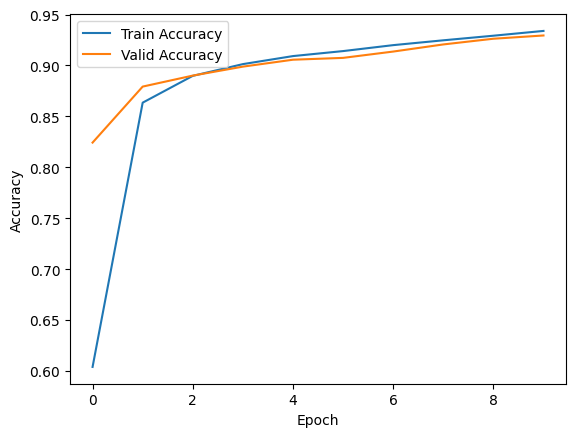

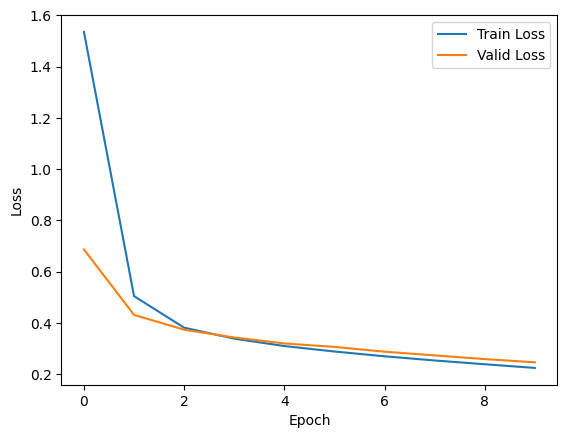

In [6]:
plt.figure()

train_acc = [float(a) for a in results['train accuracy']]
train_loss = [float(l.cpu()) if hasattr(l, 'cpu') else float(l) for l in results['train loss']]
valid_acc = [float(a) for a in results['validation accuracy']]
valid_loss = [float(l.cpu()) if hasattr(l, 'cpu') else float(l) for l in results['validation loss']]

plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test

In [7]:
# load best weights
model.load_state_dict(torch.load(save_path, map_location=device))

test_loss = 0.0
test_acc = 0.0
test_total = 0
model.eval()
for batch_idx, batch in enumerate(test_dataloader):

    # don't compute gradients during validation
    with torch.no_grad():

        # unpack data and labels
        x, y = batch
        x = x.to(device)  # we'll cover this in the next section!
        y = y.to(device)  # we'll cover this in the next section!

        # generate predictions and compute loss
        output = model(x)
        loss = loss_fn(output, y)

        # compute accuracy
        preds = output.argmax(dim=1)
        acc = preds.eq(y).sum().item()/len(y)

        # update statistics
        test_loss += (loss * len(x))
        test_acc += (acc * len(x))
        test_total += len(x)

test_loss /= test_total
test_acc /= test_total
print(f"test loss {test_loss :0.3f}, test acc {test_acc :0.3f}")

test loss 0.220, test acc 0.935


## Sources
- [Torch](https://docs.pytorch.org/docs/stable/index.html)
- [NumPy](https://numpy.org/doc/2.2/index.html)